In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [16]:
source = pd.read_excel('C:\\Users\\konstantin_kutovoy\\Documents\\BioVstu\\Регулярные\\forcast.xlsx', sheet_name='Лист2')
isoprep = source[source['Продукт'] == 'ИзоПреп, л']['Кол-во']
formalin = source[source['Продукт'] == 'Формалин 10%, л']['Кол-во'].reset_index(drop=True)
lezvia = source[source['Продукт'] == 'Лезвия, шт']['Кол-во'].reset_index(drop=True)
meshocki = source[source['Продукт'] == 'Мешочки биопсийные']['Кол-во'].reset_index(drop=True)

In [3]:
formalin

0     12980
1     14035
2     19860
3     29180
4     32420
      ...  
60    24920
61    41792
62    66780
63    45266
64    57804
Name: Кол-во, Length: 65, dtype: int64

# Simple Exponential Smoothing (SES)

In [4]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

## Изучение влияние параметра smoothing_level метода fit

In [5]:
df = pd.DataFrame(isoprep)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
for i in range(0,12,2):
    isoprep_model = SimpleExpSmoothing(isoprep).fit(smoothing_level= i / 10)
    isoprep_smooth = isoprep_model.fittedvalues
    df2 = pd.DataFrame(isoprep_smooth)
    df2.rename(columns={0:f'Smooth {i/10}'}, inplace=True)
    df = pd.concat([df, df2], axis=1)

In [6]:
df

,Base,Smooth 0.0,Smooth 0.2,Smooth 0.4,Smooth 0.6,Smooth 0.8,Smooth 1.0
0,4773,21268.682039,11848.750856,9361.876407,7645.783547,6232.266224,4773.0
1,12347,21268.682039,10433.600685,7526.325844,5922.113419,5064.853245,4773.0
2,11183,21268.682039,10816.280548,9454.595507,9777.045368,10890.570649,12347.0
3,9134,21268.682039,10889.624438,10145.957304,10620.618147,11124.514130,11183.0
4,11968,21268.682039,10538.499551,9741.174382,9728.647259,9532.102826,9134.0
...,...,...,...,...,...,...,...
60,15474,21268.682039,29039.248063,28319.345428,26616.633276,24024.735970,20604.0
61,19279,21268.682039,26326.198451,23181.207257,19931.053310,17184.147194,15474.0
62,33940,21268.682039,24916.758761,21620.324354,19539.821324,18860.029439,19279.0
63,24176,21268.682039,26721.407009,26548.194612,28179.928530,30924.005888,33940.0


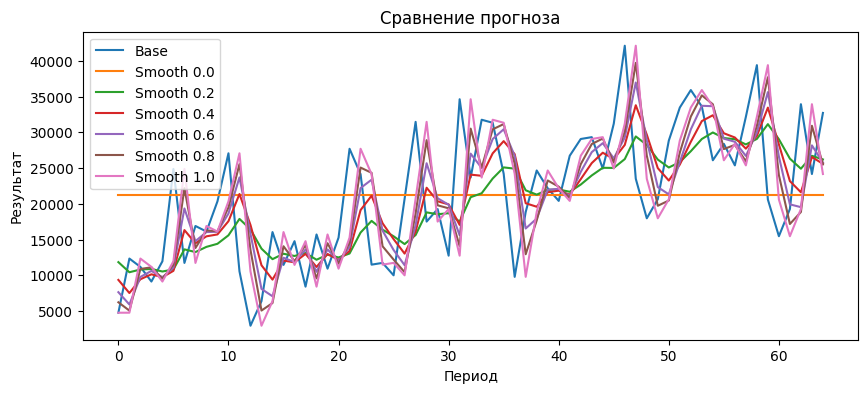

In [7]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

Как видим чем параметр smoothing_level ближе к 0, тем более выпрямленной получается зависимость<p>
При равно 0 - показывает линию среднего значения<p>
А чем ближе к 1, тем более точно повторяет изначальную зависимость

## Изучение влияние параметра initialization_method в модели

In [8]:
df = pd.DataFrame(isoprep)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
for i in [None,'estimated','heuristic','legacy-heuristic']:
    isoprep_model = SimpleExpSmoothing(isoprep,initialization_method=i).fit(smoothing_level=0.5, optimized=False)
    isoprep_smooth = isoprep_model.fittedvalues
    df2 = pd.DataFrame(isoprep_smooth)
    df2.rename(columns={0:f'{i}'}, inplace=True)
    df = pd.concat([df, df2], axis=1)

In [9]:
df

,Base,None,estimated,heuristic,legacy-heuristic
0,4773,4773.000000,6740.866667,6740.866667,4773.000000
1,12347,4773.000000,5756.933333,5756.933333,4773.000000
2,11183,8560.000000,9051.966667,9051.966667,8560.000000
3,9134,9871.500000,10117.483333,10117.483333,9871.500000
4,11968,9502.750000,9625.741667,9625.741667,9502.750000
...,...,...,...,...,...
60,15474,27573.951420,27573.951420,27573.951420,27573.951420
61,19279,21523.975710,21523.975710,21523.975710,21523.975710
62,33940,20401.487855,20401.487855,20401.487855,20401.487855
63,24176,27170.743927,27170.743927,27170.743927,27170.743927


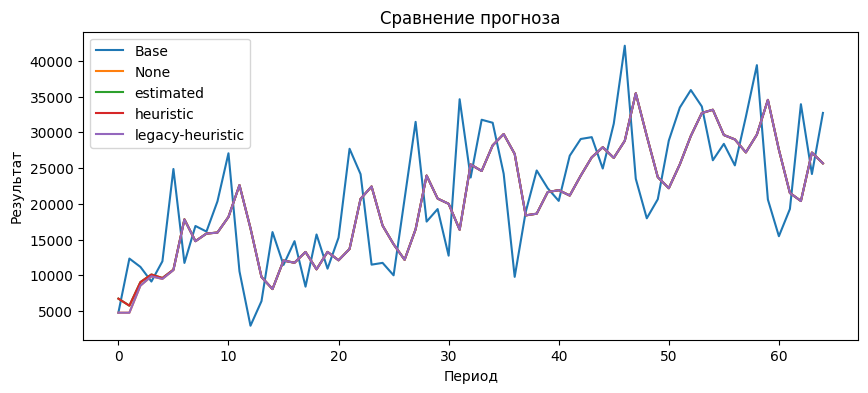

In [10]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

Параметр initialization_method при прочих равных параметрах влияет только при первых 5 шагах, далее значения становятся идентичными

Отдельно сравним зависимости при значении параметра initialization_method = known

In [11]:
df = pd.DataFrame(isoprep)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
isoprep_model = SimpleExpSmoothing(isoprep,initialization_method=None).fit(smoothing_level=0.5, optimized=False)
isoprep_smooth = isoprep_model.fittedvalues
df1 = pd.DataFrame(isoprep_smooth)
df1.rename(columns={0:'None'}, inplace=True)
df = pd.concat([df, df1], axis=1)
isoprep_model = SimpleExpSmoothing(isoprep,initialization_method='known', initial_level=0.9).fit(smoothing_level=0.5, optimized=False)
isoprep_smooth = isoprep_model.fittedvalues
df2 = pd.DataFrame(isoprep_smooth)
df2.rename(columns={0:'known'}, inplace=True)
df = pd.concat([df, df2], axis=1)

In [12]:
df

,Base,None,known
0,4773,4773.000000,0.900000
1,12347,4773.000000,2386.950000
2,11183,8560.000000,7366.975000
3,9134,9871.500000,9274.987500
4,11968,9502.750000,9204.493750
...,...,...,...
60,15474,27573.951420,27573.951420
61,19279,21523.975710,21523.975710
62,33940,20401.487855,20401.487855
63,24176,27170.743927,27170.743927


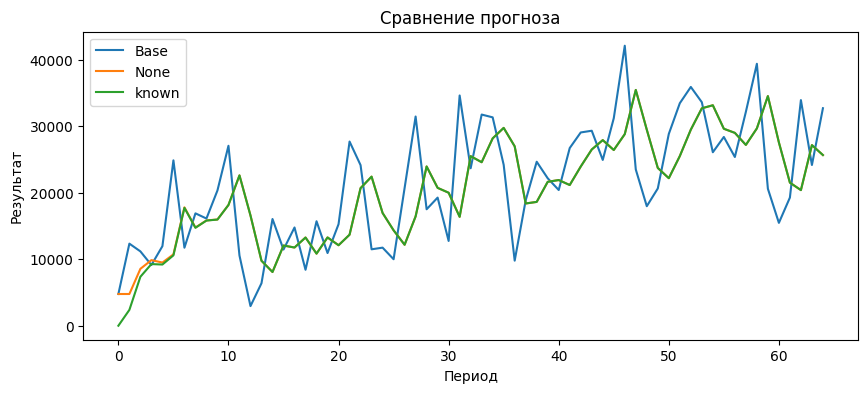

In [13]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

Таким образом параметр initialization_method служит для указания правила начальных значений<p>
    <ul>
        <li>оцененный</li>
        <li>эвристический</li>
        <li>наследованно-эфристический</li>
        <li>известный, в этом случае начальное значение указывается непосредственно в initial_level</li>        
</ul>

## Изучение влияние параметра remove_bias метода fit

In [104]:
df = pd.DataFrame(meshocki)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
meshocki_model = SimpleExpSmoothing(meshocki).fit(smoothing_level=0.2, remove_bias=True, optimized=True)
meshocki_smooth = meshocki_model.fittedvalues
df1 = pd.DataFrame(meshocki_smooth)
df1.rename(columns={0:'True'}, inplace=True)
df = pd.concat([df, df1], axis=1)
meshocki_model = SimpleExpSmoothing(meshocki).fit(smoothing_level=0.2, remove_bias=False, optimized=True)
meshocki_smooth = meshocki_model.fittedvalues
df2 = pd.DataFrame(meshocki_smooth)
df2.rename(columns={0:'False'}, inplace=True)
df = pd.concat([df, df2], axis=1)

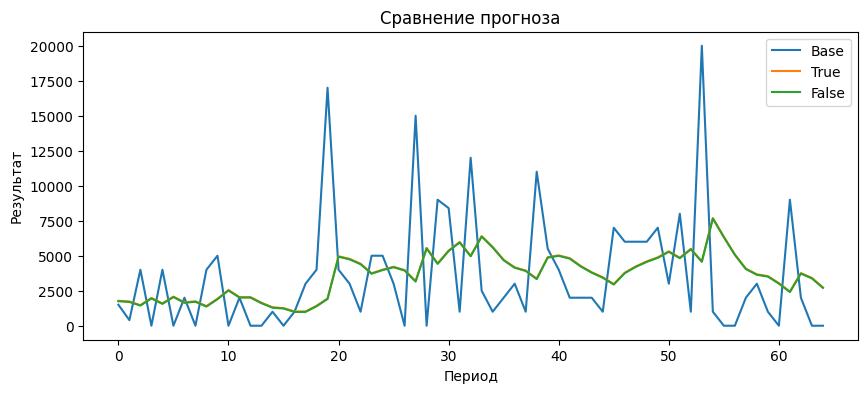

In [105]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

Даже при работе с данными, содержащими нули, разницы в параметре не замечено

# Holt Winter’s Exponential Smoothing (HWES)

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [68]:
df = pd.DataFrame(isoprep)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
isoprep_model = SimpleExpSmoothing(isoprep).fit(smoothing_level=0.5)
isoprep_smooth = isoprep_model.fittedvalues
df1 = pd.DataFrame(isoprep_smooth)
df1.rename(columns={0:'SES'}, inplace=True)
df = pd.concat([df, df1], axis=1)
isoprep_model = ExponentialSmoothing(isoprep, trend='mul', seasonal='add', seasonal_periods=3).fit(smoothing_level=0.1, smoothing_trend=0.9, smoothing_seasonal=0.9, optimized=True)
isoprep_smooth = isoprep_model.fittedvalues
df2 = pd.DataFrame(isoprep_smooth)
df2.rename(columns={0:'HWES'}, inplace=True)
df = pd.concat([df, df2], axis=1)
'''“add”, “mul”, “additive”, “multiplicative”, '''

C:\Users\konstantin_kutovoy\.jup\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


'“add”, “mul”, “additive”, “multiplicative”, '

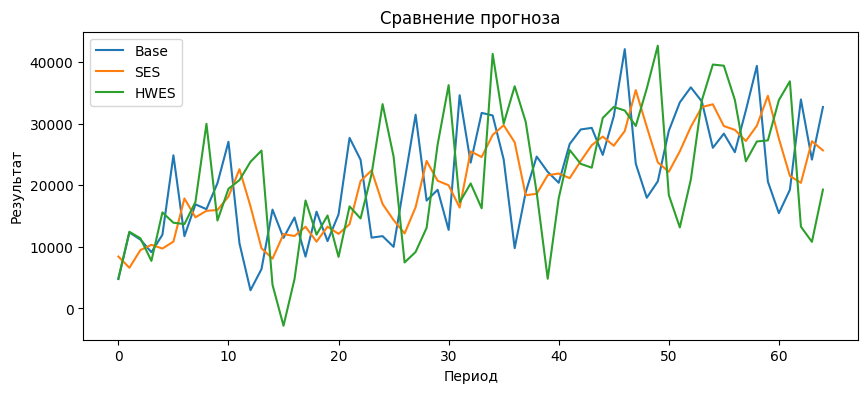

In [69]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

In [63]:
df

,Base,SES,HWES
0,4773,8431.655557,4781.864426
1,12347,6602.327779,10412.452225
2,11183,9474.663889,12869.004815
3,9134,10328.831945,4897.271480
4,11968,9731.415972,13622.361852
...,...,...,...
60,15474,27573.951420,29469.390970
61,19279,21523.975710,25738.033744
62,33940,20401.487855,10376.787643
63,24176,27170.743927,24026.089307


# Holt’s Exponential Smoothing

In [70]:
from statsmodels.tsa.holtwinters import Holt

In [108]:
df = pd.DataFrame(isoprep)
df.rename(columns={'Кол-во':'Base'}, inplace=True)
isoprep_model = SimpleExpSmoothing(isoprep).fit(smoothing_level=0.1, optimized=True)
isoprep_smooth = isoprep_model.fittedvalues
df1 = pd.DataFrame(isoprep_smooth)
df1.rename(columns={0:'SES'}, inplace=True)
df = pd.concat([df, df1], axis=1)
isoprep_model = Holt(isoprep, exponential=False).fit(smoothing_level=0.1, smoothing_trend=0.5, optimized=True)
isoprep_smooth = isoprep_model.fittedvalues
df2 = pd.DataFrame(isoprep_smooth)
df2.rename(columns={0:'Holt'}, inplace=True)
df = pd.concat([df, df2], axis=1)

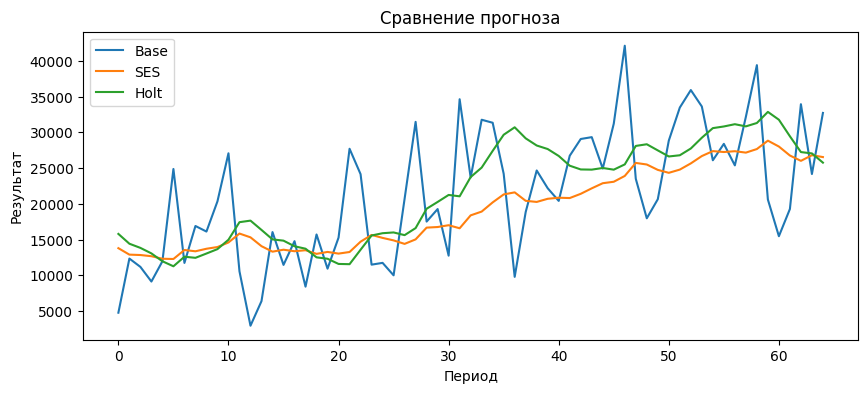

In [109]:
plt.figure(figsize=(10, 4))
for col in df.columns:
    sns.lineplot(x=df.index, y=df[col], label=f'{col}')
plt.title('Сравнение прогноза')
plt.xlabel('Период')
plt.ylabel('Результат')
plt.legend()
plt.show()

In [110]:
df

,Base,SES,Holt
0,4773,13800.747462,15796.050248
1,12347,12897.972716,14423.423627
2,11183,12842.875445,13841.638486
3,9134,12676.887900,13068.699936
4,11968,12322.599110,11971.420244
...,...,...,...
60,15474,28017.706064,31768.585731
61,19279,26763.335457,29454.962422
62,33940,26014.901911,27244.403323
63,24176,26807.411720,27055.779968


In [115]:
fit = isoprep_model.fittedfcast[1:]
fit

array([14423.42362671, 13841.63848642, 13068.69993583, 11971.42024351,
       11267.09750825, 12604.7521711 , 12450.85375911, 13052.05250037,
       13668.77874248, 14980.54342325, 17437.80446479, 17654.39917893,
       16353.46446271, 15028.14999498, 14852.90947427, 14066.39753192,
       13726.11690721, 12518.10849961, 12320.84550779, 11595.81653976,
       11561.39964154, 13580.80445107, 15571.7785571 , 15893.96632466,
       16001.38699924, 15623.9462564 , 16610.00227502, 19315.95257803,
       20266.51022183, 21247.48659017, 21054.19099216, 23747.31540434,
       25073.06160509, 27409.03010551, 29666.00025061, 30710.82336868,
       29163.2230065 , 28162.97153021, 27668.44662504, 26700.35187914,
       25338.09901387, 24813.01648443, 24787.99138372, 25018.46922389,
       24782.92581885, 25519.34046337, 28103.19662027, 28337.45733047,
       27477.71910312, 26629.26874335, 26797.0499824 , 27743.90059841,
       29249.52112291, 30593.20353881, 30825.40753618, 31142.520757  ,
      

In [116]:
len(fit)

65